In [3]:
import numpy as np
import pandas as pd

import tensorflow as tf
import pickle
from tensorflow.keras import layers , activations , models , preprocessing, utils
import re

import yaml
import os

dir_path = '/content/datas'
files_list = os.listdir(dir_path + os.sep)
files_list

['JAWA.yml', 'ENGLISH.yml']

In [4]:
questions, answers = [], []

for filepath in files_list:
    file_ = open(dir_path + os.sep + filepath , 'rb')
    docs = yaml.safe_load(file_)
    conversations = docs['conversations']
    for con in conversations:
        if len(con) > 2 :
            questions.append(con[0])
            replies = con[1 :]
            ans = ''
            for rep in replies:
                ans += ' ' + rep
            answers.append(ans)
        elif len(con)> 1:
            questions.append(con[0])
            answers.append(con[1])

In [5]:
answers

['Wes kangen banget karo rasane Soto Lamongan sing wingi di nikmati, dadi pengen enggal bali ngrasakno maneh. seneng maneh.',
 'Aku seneng banget karo panganan Soto Lamongan sing enak. Sambelnya enak banget, daging ayamnya empuk, bumbunya pas. Rasane enak banget, mula aku pengin nyoba maneh ing wektu liyane.',
 'dheweke milih ngrasakake khas daerah, yaiku pempek, ing sangisore ayang-ayangan megah Jembatan Ampera.',
 'padha seneng banget karo masakan pitik ing Warung Ayam Nelongo, sinambi ngrasakake swasana nyaman ing kono.',
 'dheweke sregep ngrasakake segelas dawet ijo seger ing pinggir dalan sing rame.',
 'Bakso Malang misuwur kanthi saos kental sing enak lan pentol goreng sing gurih, dadi panganan sing disenengi ing Malang.',
 'Sampeyan bisa nyoba sarapan tradisional Malang ing Warung Kampoeng Tempo Doeloe, ngendi padha nyediakake masakan kaya bubur ayam asli lan sega pecel.',
 'Jajan jalanan ing Alun-Alun Malang populer amarga macem-macem pilihan panganan wiwit saka bakso nganti ja

In [6]:
answers_with_tags = []
for i in range(len(answers)):
    if type(answers[i]) == str:
        answers_with_tags.append(answers[i])
    else:
        questions.pop(i)

answers = []
for i in range(len(answers_with_tags)) :
    answers.append('<START> ' + answers_with_tags[i] + ' <END>')

tokenizer = preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(questions + answers)
VOCAB_SIZE = len(tokenizer.word_index)+1

In [7]:
from gensim.models import Word2Vec
import re

vocab = []
for word in tokenizer.word_index:
    vocab.append(word)

def tokenize(sentences):
    tokens_list = []
    vocabulary = []
    for sentence in sentences:
        sentence = sentence.lower()
        sentence = re.sub('[^a-zA-Z]', ' ', sentence)
        tokens = sentence.split()
        vocabulary += tokens
        tokens_list.append(tokens)
    return tokens_list , vocabulary

In [8]:
# encoder_input_data
tokenized_questions = tokenizer.texts_to_sequences(questions)
maxlen_questions = max([len(x) for x in tokenized_questions])
padded_questions = preprocessing.sequence.pad_sequences(tokenized_questions , maxlen=maxlen_questions , padding='post')
encoder_input_data = np.array(padded_questions)

In [9]:
encoder_input_data.shape

(2000, 31)

In [10]:
# decoder_input_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
maxlen_answers = max([len(x) for x in tokenized_answers])
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers , maxlen=maxlen_answers , padding='post')
decoder_input_data = np.array(padded_answers)

In [11]:
decoder_input_data.shape

(2000, 76)

In [12]:
# decoder_output_data
tokenized_answers = tokenizer.texts_to_sequences(answers)
for i in range(len(tokenized_answers)) :
    tokenized_answers[i] = tokenized_answers[i][1:]
padded_answers = preprocessing.sequence.pad_sequences(tokenized_answers , maxlen=maxlen_answers , padding='post')
onehot_answers = utils.to_categorical(padded_answers , VOCAB_SIZE)
decoder_output_data = np.array(onehot_answers)

In [13]:
decoder_output_data.shape

(2000, 76, 3867)

In [14]:
# Embedding, LSTM and Desne layers
encoder_inputs = tf.keras.layers.Input(shape=(maxlen_questions ,))
encoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200 , mask_zero=True) (encoder_inputs)
encoder_outputs , state_h , state_c = tf.keras.layers.LSTM(200 , return_state=True)(encoder_embedding)
encoder_states = [ state_h , state_c ]

decoder_inputs = tf.keras.layers.Input(shape=(maxlen_answers , ))
decoder_embedding = tf.keras.layers.Embedding(VOCAB_SIZE, 200 , mask_zero=True) (decoder_inputs)
decoder_lstm = tf.keras.layers.LSTM(200 , return_state=True , return_sequences=True)
decoder_outputs , _ , _ = decoder_lstm (decoder_embedding , initial_state=encoder_states)


decoder_dense = tf.keras.layers.Dense(VOCAB_SIZE , activation=tf.keras.activations.softmax)
output = decoder_dense (decoder_outputs)

# model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output)

In [15]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))

Found GPU at: /device:GPU:0


In [16]:
with tf.device(device_name):
    model = tf.keras.models.Model([encoder_inputs, decoder_inputs], output) # Create a TensorFlow model.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy']) # Compile the model on the GPU.
# Once the model has been created and compiled on the GPU, it can be
# trained as per usual.

In [17]:
# model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 31)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 76)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 31, 200)              773400    ['input_1[0][0]']             
                                                                                                  
 embedding_1 (Embedding)     (None, 76, 200)              773400    ['input_2[0][0]']             
                                                                                              

In [19]:
model.fit([encoder_input_data , decoder_input_data], decoder_output_data, batch_size=16, epochs=100)

Epoch 1/100
125/125 [==============================] - 31s 147ms/step - loss: 6.5864 - accuracy: 0.0936
Epoch 2/100
125/125 [==============================] - 8s 63ms/step - loss: 5.8423 - accuracy: 0.1330
Epoch 3/100
125/125 [==============================] - 7s 53ms/step - loss: 5.5663 - accuracy: 0.1508
Epoch 4/100
125/125 [==============================] - 5s 41ms/step - loss: 5.1431 - accuracy: 0.1783
Epoch 5/100
125/125 [==============================] - 5s 41ms/step - loss: 4.8686 - accuracy: 0.2012
Epoch 6/100
125/125 [==============================] - 5s 38ms/step - loss: 4.6556 - accuracy: 0.2244
Epoch 7/100
125/125 [==============================] - 4s 31ms/step - loss: 4.4636 - accuracy: 0.2437
Epoch 8/100
125/125 [==============================] - 5s 41ms/step - loss: 4.2832 - accuracy: 0.2597
Epoch 9/100
125/125 [==============================] - 4s 31ms/step - loss: 4.1146 - accuracy: 0.2742
Epoch 10/100
125/125 [==============================] - 4s 28ms/step - loss: 3.9

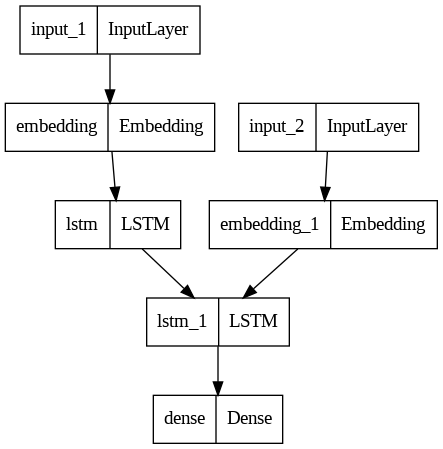

In [20]:
tf.keras.utils.plot_model(model)

In [21]:
#Prediction

In [42]:
def inference():

    encoder_model = tf.keras.models.Model(encoder_inputs, encoder_states)

    decoder_state_input_h = tf.keras.layers.Input(shape=(200 ,))
    decoder_state_input_c = tf.keras.layers.Input(shape=(200 ,))

    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    decoder_outputs, state_h, state_c = decoder_lstm(decoder_embedding , initial_state=decoder_states_inputs)
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)

    decoder_model = tf.keras.models.Model([decoder_inputs] + decoder_states_inputs,[decoder_outputs] + decoder_states)

    return encoder_model , decoder_model

def preprocess_input(input_sentence):
    tokens = input_sentence.lower().split()
    tokens_list = []
    for word in tokens:
        tokens_list.append(tokenizer.word_index[word])
    return preprocessing.sequence.pad_sequences([tokens_list] , maxlen=maxlen_questions , padding='post')

In [43]:
enc_model , dec_model = inference()

In [44]:
# tests = ['You can not move', 'You sound like Data', 'Stupid', 'you are idiot', 'i am going to die']

# for i in range(5):
#     states_values = enc_model.predict(preprocess_input(tests[i]))
#     empty_target_seq = np.zeros((1 , 1))
#     empty_target_seq[0, 0] = tokenizer.word_index['start']
#     stop_condition = False
#     decoded_translation = ''

#     while not stop_condition :
#         dec_outputs , h , c = dec_model.predict([empty_target_seq] + states_values)
#         sampled_word_index = np.argmax(dec_outputs[0, -1, :])
#         sampled_word = None

#         for word , index in tokenizer.word_index.items() :
#             if sampled_word_index == index :
#                 decoded_translation += f' {word}'
#                 sampled_word = word

#         if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
#             stop_condition = True

#         empty_target_seq = np.zeros((1 , 1))
#         empty_target_seq[0 , 0] = sampled_word_index
#         states_values = [h , c]
#     print(f'Human: {tests[i]}')
#     print()
#     decoded_translation = decoded_translation.split(' end')[0]
#     print(f'Bot: {decoded_translation}')
#     print('-'*25)

In [45]:
#A python program to illustrate Caesar Cipher Technique
def encrypt(text,s):
	result = ""

	# traverse text
	for i in range(len(text)):
		char = text[i]

		# Encrypt uppercase characters
		if (char.isupper()):
			result += chr((ord(char) + s-65) % 26 + 65)

		# Encrypt lowercase characters
		else:
			result += chr((ord(char) + s - 97) % 26 + 97)

	return result

#check the above function
text = "ATTACKATONCE"
s = 4
print ("Text : " + text)
print ("Shift : " + str(s))
print ("Cipher: " + encrypt(text,s))

Text : ATTACKATONCE
Shift : 4
Cipher: EXXEGOEXSRGI


In [46]:
from random import randrange
error_respond = ['i dont know what do you mean.', 'Sorry...', 'What?', 'Wth?']

In [60]:
from typing import Tuple
def chat(text) -> Tuple[str, str]:
    try:
        states_values = enc_model.predict(preprocess_input(text), verbose=0)
        empty_target_seq = np.zeros((1 , 1))
        empty_target_seq[0, 0] = tokenizer.word_index['start']
        stop_condition = False
        decoded_translation = ''

        while not stop_condition :
            dec_outputs , h , c = dec_model.predict([empty_target_seq] + states_values, verbose=0)
            sampled_word_index = np.argmax(dec_outputs[0, -1, :])
            sampled_word = None

            for word , index in tokenizer.word_index.items() :
                if sampled_word_index == index :
                    decoded_translation += f' {word}'
                    sampled_word = word

            if sampled_word == 'end' or len(decoded_translation.split()) > maxlen_answers:
                stop_condition = True

            empty_target_seq = np.zeros((1 , 1))
            empty_target_seq[0 , 0] = sampled_word_index
            states_values = [h , c]
            decoded_translation = decoded_translation.split(' end')[0]

    except:
        randomNum = randrange(4)
        decoded_translation = error_respond[randomNum]
    finally:
        # print(f'Human: {text}')
        # print()
        # print(f'Bot: {decoded_translation}')
        # print('-'*25)
        # print(encrypt(decoded_translation,4))
        encrypted = encrypt(decoded_translation,4)
        return decoded_translation, encrypted


In [61]:
chat("where is meatball ")

(' bakpia pathok is a savory and spicy taste',
 'rfeotmertexlsormwrerwezsvcrerhrwtmgcrxewxi')

In [62]:
def get_user_input():
    user_input = input("Q: ")
    return user_input

def show_answer(question):
    # Replace this with your model prediction logic
    decoded_translation, encrypted = chat(question)
    answer = f"A: {decoded_translation} \nEnkripsi: {encrypted}"
    print(answer)

# Main loop
while True:
    user_question = get_user_input()
    if user_question == 'bye':
        break
    show_answer(user_question)
    # user_continue = input("Do you want to ask another question? (yes/no): ").lower()


Q: hi
A: What? 
Enkripsi: Alexw
Q: what is bakso
A:  bakso is a typical indonesian food 
Enkripsi: rfeowsrmwrerxctmgeprmrhsriwmerrjssh
Q: explain it
A: Sorry... 
Enkripsi: Wsvvcfff
Q: what is bakso in details
A: Sorry... 
Enkripsi: Wsvvcfff
Q: what is bakso malang
A:  bakso malang is typical betawi especially because of its tender and crunchy with spicy chili sauce usually served with spicy chili sauce 
Enkripsi: rfeowsrqeperkrmwrxctmgeprfixeamriwtigmeppcrfigeywirsjrmxwrxirhivrerhrgvyrglcramxlrwtmgcrglmpmrweygirywyeppcrwivzihramxlrwtmgcrglmpmrweygi
Q: bye
